# Estimating correlation through analytical calculations and random walk

## Random walk versus analytical calculation

When the uncertainty on the parameters has to be estimated for the case of fitting through the loglikelihood, another option presents itself.

Using a random walk through parameter space, the distribution for each parameter can be explored and used to estimate both the best value and the uncertainty boundaries. This approach has the added advantage that the code is more stable: using the analytical calculations, the repeated fitting can slightly change the numbers involved, making the code a bit more fragile. The disadvantage of the random walk is that convergence is not guaranteed, nor can the number of steps needed be calculated beforehand.

Another advantage of the random walk is that the correlation between parameters is automatically calculated as well.

For the example dataset:

C:\Anaconda3\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


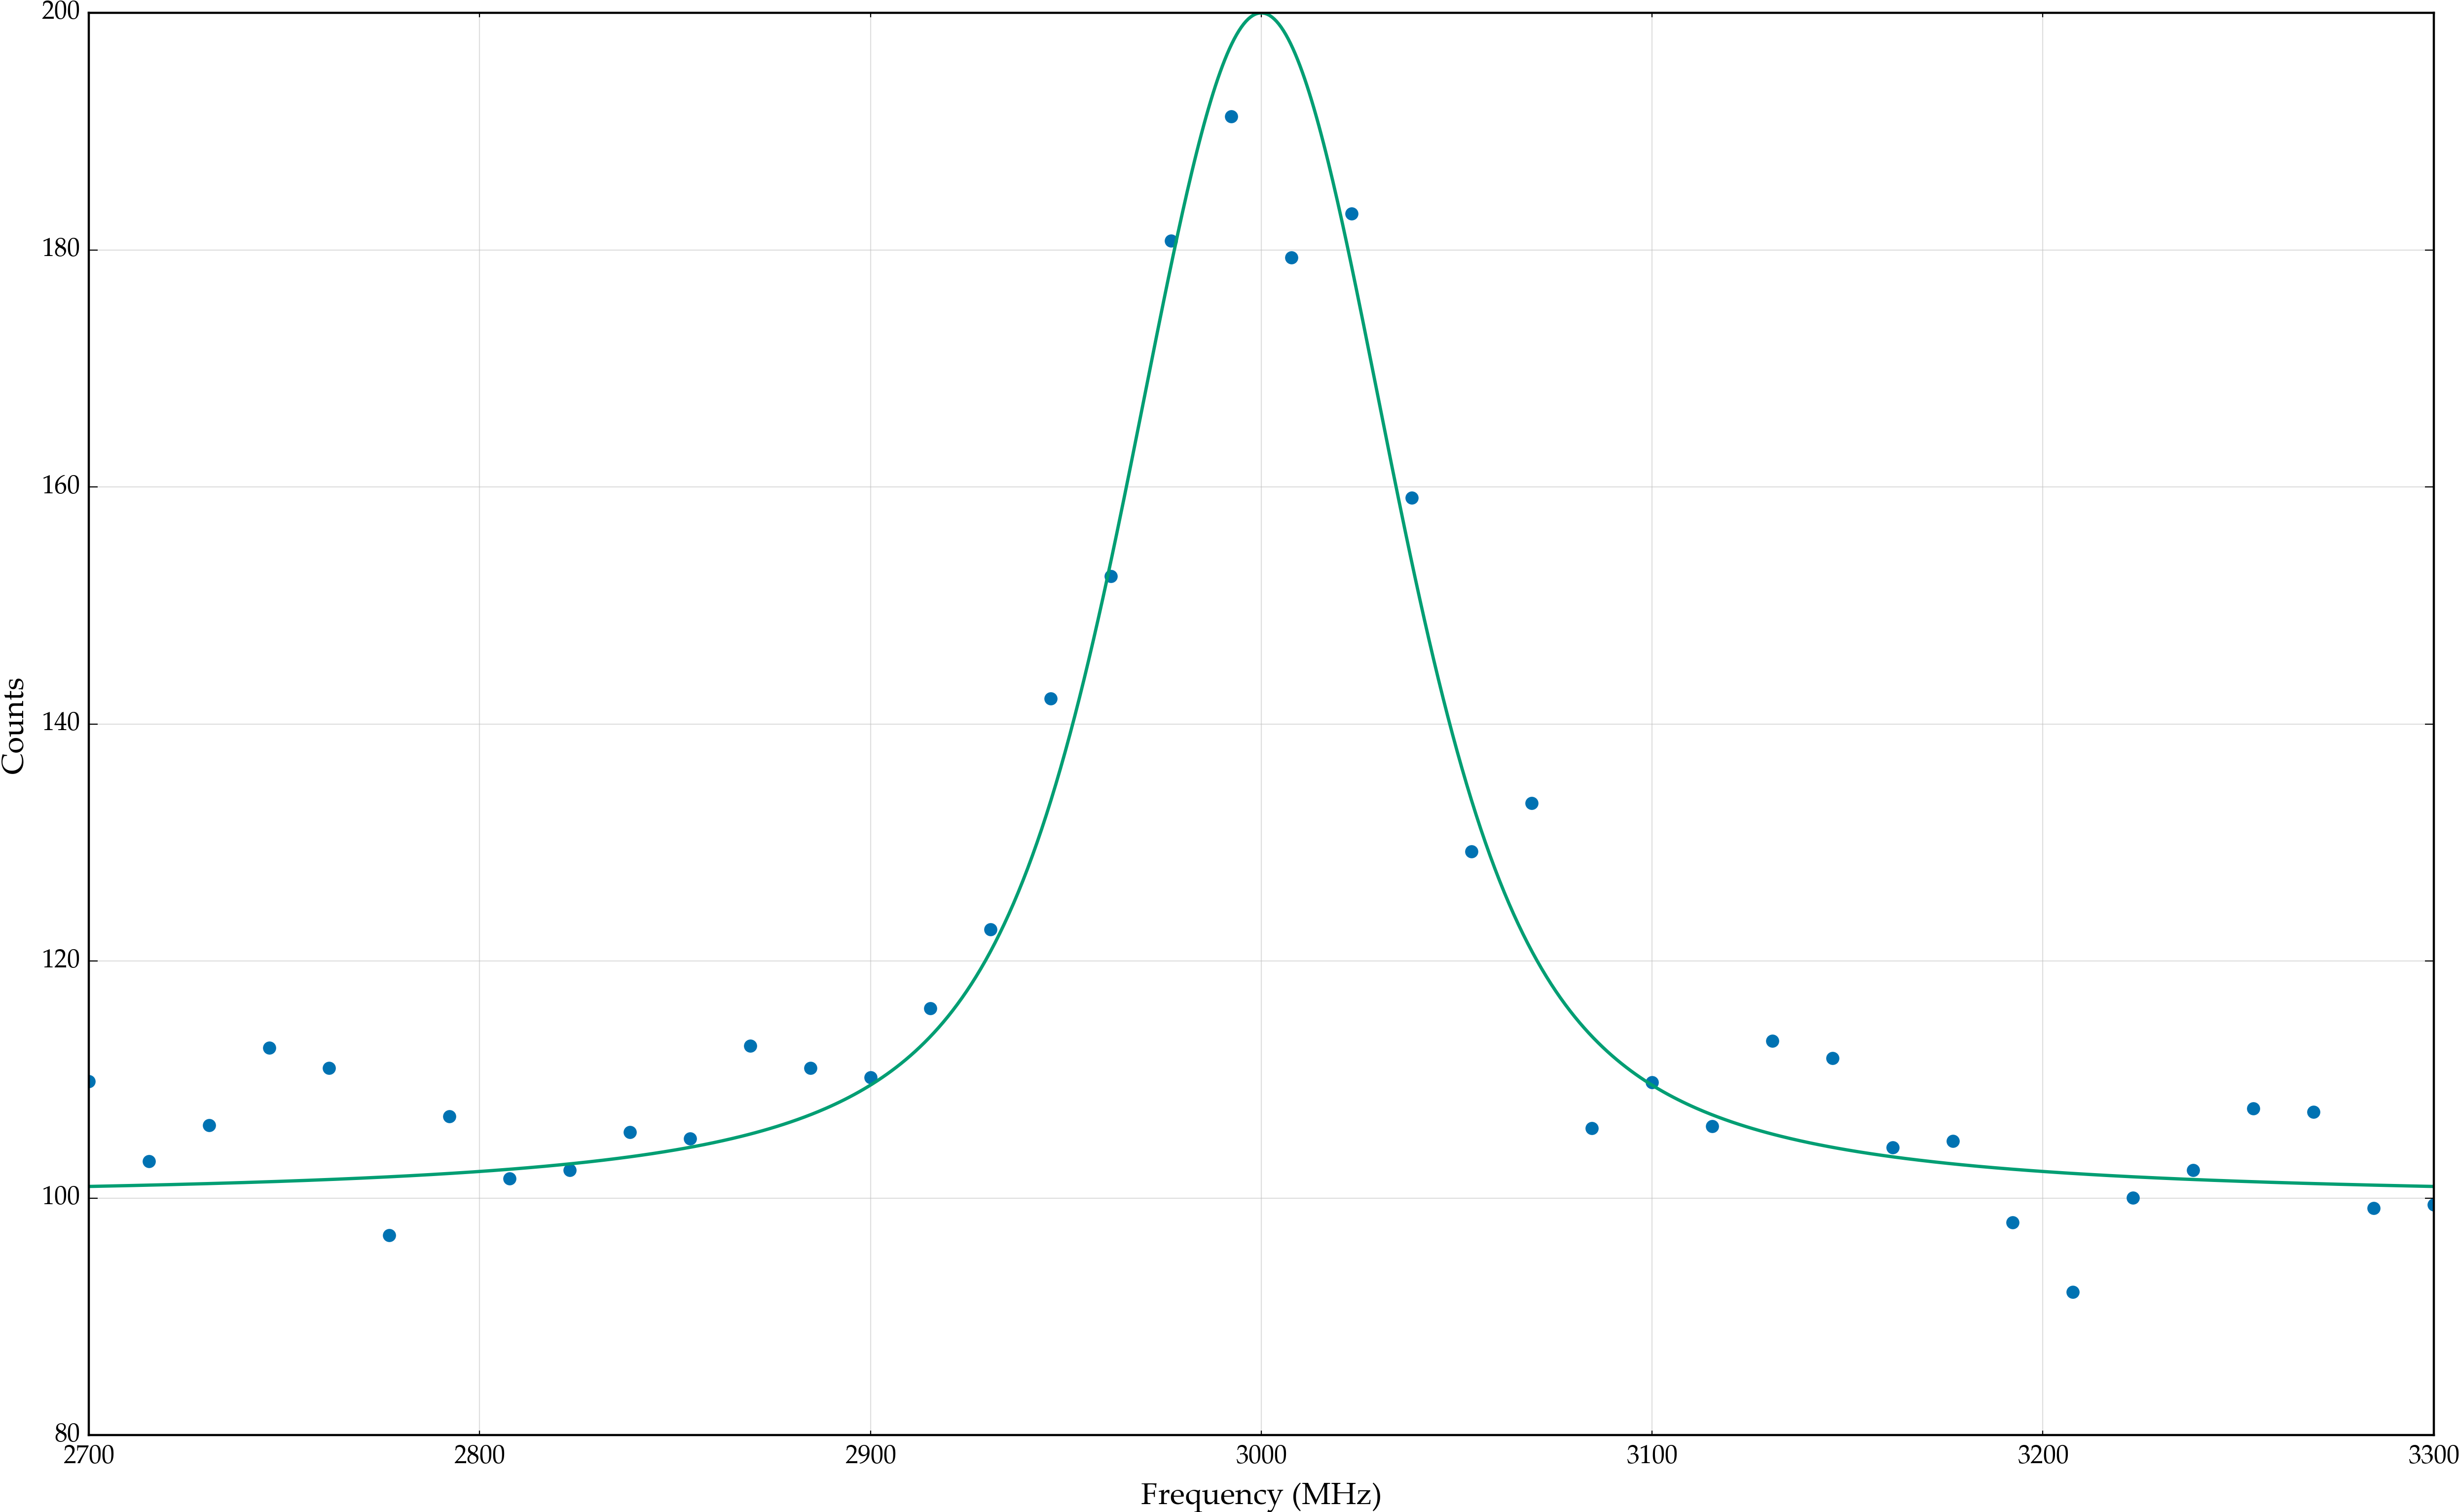

(<matplotlib.figure.Figure at 0xbc46278>,
 <matplotlib.axes._subplots.AxesSubplot at 0xbd75ef0>)

In [1]:
%matplotlib inline

import satlas as s
import numpy as np
s.set(['standard', 'online'])
np.random.seed(0)

I = 0
J = [1.0, 2.0]

ABC = [0, 0, 0, 0, 0, 0]
df = 3000
scale = 100
background = [100]

base = s.HFSModel(I, J, ABC, df, scale=scale, background_params=background)

frequency = np.linspace(2700, 3300, 40)
response = base(frequency) + 0.5*np.random.randn(frequency.size) * base(frequency)**0.5
base.plot(x=frequency, y=response)

## Analytical correlation maps

To make analytical correlation maps and 1D likelihood parabola's, the command is

Likelihood fitting done: 3454it [00:01, 2459.97it/s]                        
Finished Hessian calculation: 7it [00:00, 30.57it/s]
FWHML (root found: 74.9711582267242): 4it [00:27,  8.26s/it]
FWHML (left limit reached): 1it [00:01,  1.81s/it]
FWHML: 100%|███████████████████████████████████| 20/20 [00:16<00:00,  1.50it/s]
Centroid (root found: 3003.5123326923385): 5it [00:12,  3.68s/it]
Centroid (root found: 2995.265143228265): 2it [00:13,  4.49s/it]
Centroid: 100%|████████████████████████████████| 20/20 [00:08<00:00,  2.44it/s]
Background0 (root found: 105.4922066337488): 5it [00:38, 11.14s/it]
Background0 (root found: 99.46673147114859): 2it [00:22,  7.39s/it]
Centroid Background0: 100%|██████████████████| 400/400 [03:02<00:00,  2.39it/s]


(<matplotlib.figure.Figure at 0xc730080>,
 array([[<matplotlib.axes._axes.Axes object at 0x000000000C79D860>, None,
         None],
         <matplotlib.axes._axes.Axes object at 0x000000000D837D30>, None],
         <matplotlib.axes._axes.Axes object at 0x000000000D888E10>]], dtype=object),
 <matplotlib.colorbar.Colorbar at 0xd8167f0>)

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


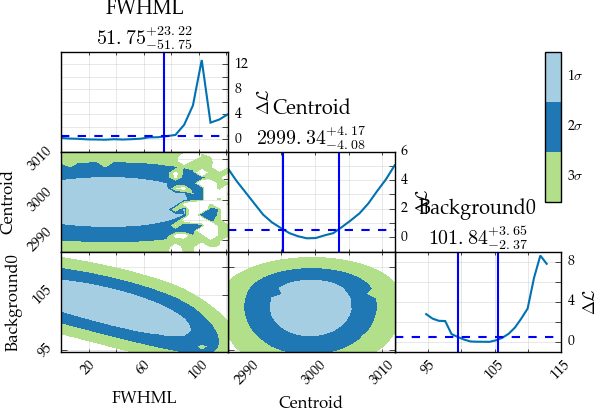

In [2]:
s.likelihood_fit(base, frequency, response)
s.generate_correlation_map(base, frequency, response, method='mle', resolution_diag=20, resolution_map=20, filter=['FWHML', 'Background0', 'Centroid'])

As can be seen here, the resolution of the correlation maps is clearly visible. Since the resolution defines the number of datapoints on each axis, the calculation time goes as $N^2$, so increasing the resolution increases the calculation time drastically.

Also clearly visible is the fact that the uncertainties are, at least in some cases, non-gaussian. Especially in the FWHM of the profile and in the background parameter, the deviation from a parabolic behaviour is evident.

## Generating and plotting random walks

Initiating the random walk can be done by using the dedicated function, or by passing the *walking=True* keyword to the likelihood fitting method, which will automatically start the walk.

Due to memory concerns, the results from the random walk are saved in a file in either the current directory if only the filename is given, or in another directory if that location is also given.

The random walk algorithm employs the *emcee* package, and more details on arguments for the walk algorithm can be found there.

In [3]:
s.likelihood_fit(base, frequency, response, walking=True, walk_kws={'filename': 'demonstration.h5', 'nsteps': 10000})

Likelihood fitting done: 2529it [00:01, 2326.45it/s]                       
Finished Hessian calculation: 7it [00:00, 29.29it/s]
Walk: 100%|█████████████████████████████| 10000/10000 [01:00<00:00, 164.71it/s]


(True, 'Converged (|f_n-f_(n-1)| ~= 0)')

Centroid Background0: 100%|██████████████████| 15/15.0 [00:02<00:00,  7.12it/s]


(<matplotlib.figure.Figure at 0x105bf828>,
 array([[<matplotlib.axes._axes.Axes object at 0x00000000105289B0>, None,
         None, None, None],
         <matplotlib.axes._axes.Axes object at 0x000000001514E400>, None,
         None, None],
         <matplotlib.axes._axes.Axes object at 0x0000000015168470>, None,
         None],
         <matplotlib.axes._axes.Axes object at 0x000000001515CF28>, None],
         <matplotlib.axes._axes.Axes object at 0x0000000015475908>]], dtype=object),
 <matplotlib.colorbar.Colorbar at 0x10683278>)

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


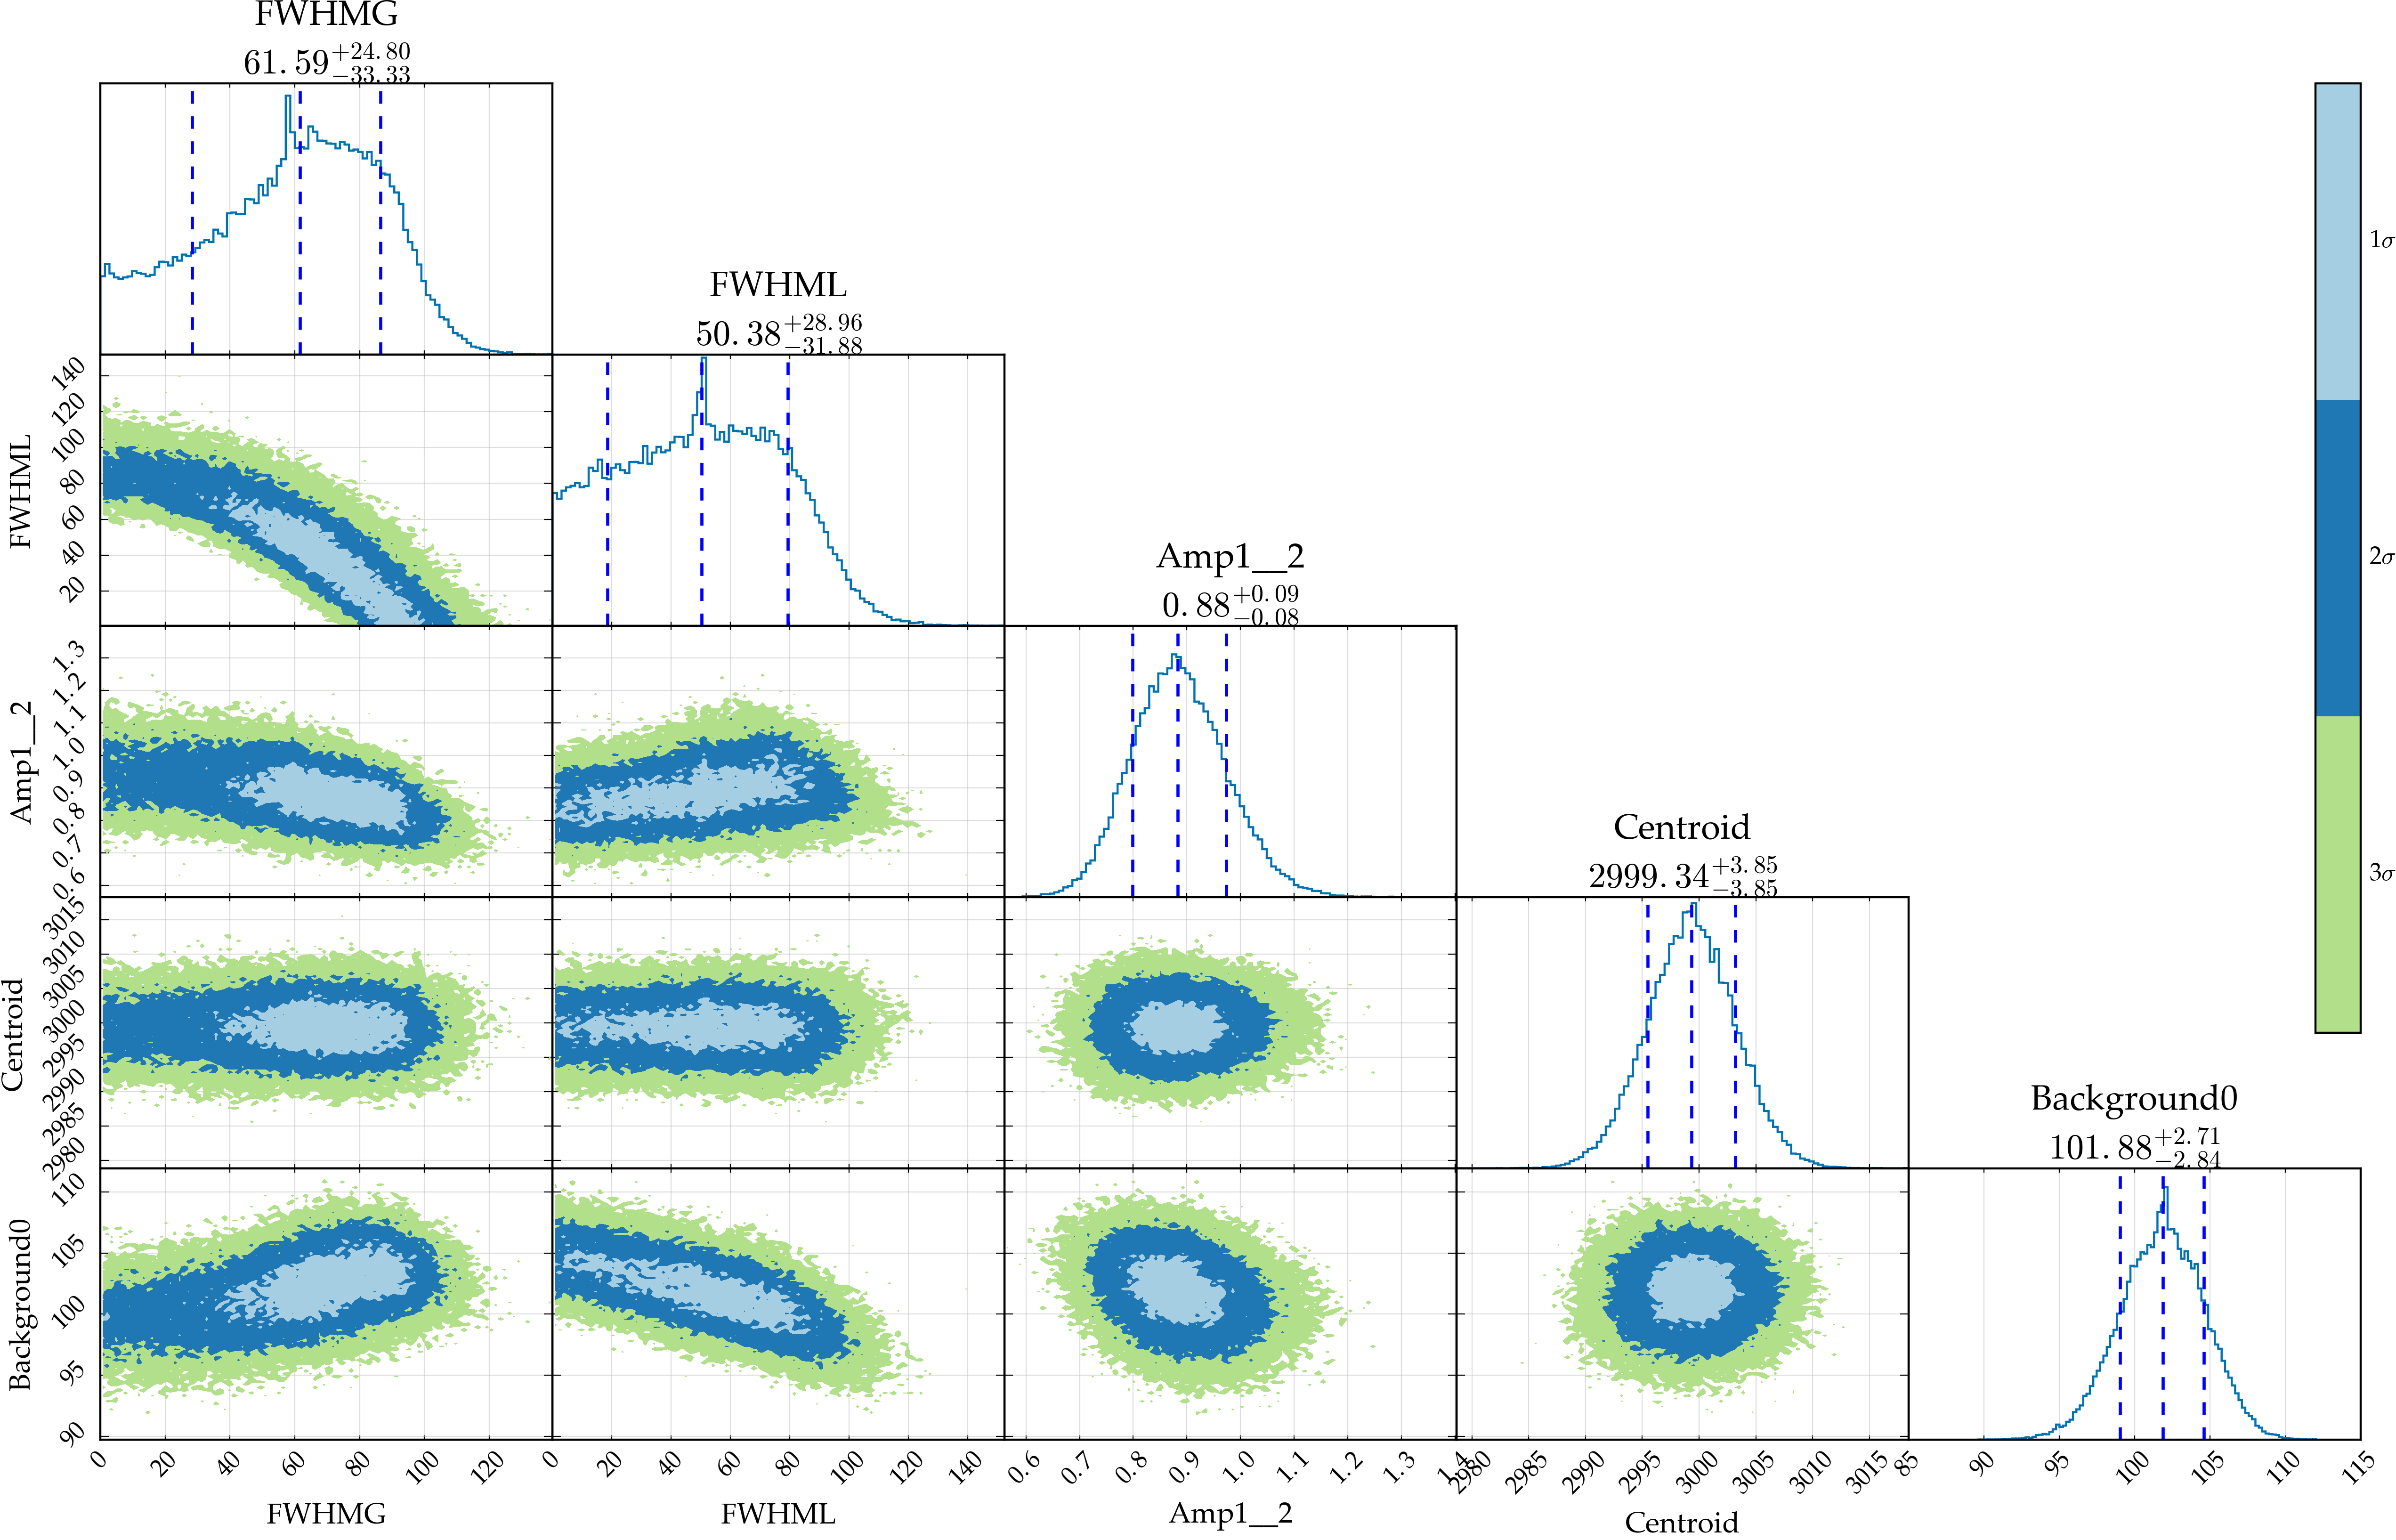

In [2]:
s.generate_correlation_plot('demonstration.h5', bins=100)

We see that the correlation plots show the same behaviour as in the analytical case. A small one-bin peak is also still evident in most of the plots. This might be the result of burnin (see the *emcee* documentation for more information on this).

## Comparison of the two methods

The main difference between the two methods is that the analytical method works by continuously fitting and refitting the data, while the random walk judges the quality of each random step. This results in an important distinction, namely that **the analytical method might not converge**, while the random walk might get into a region where there is no difference between random steps, and **will therefore explore the entire region**, instead of being confined to the best fitting area.
Both options have their pros, cons and gotchas, and care needs to be taken in selecting which method is to be used.